# HW2 for CS 135 in Fall 2023

[Main assignment instructions here](https://www.cs.tufts.edu/cs/135/2024f/Assignments/hw2.html)

This notebook is specifically for the report related to Problem 2

# Problem 2: Binary Classifier for Cancer-Risk Screening 

### Note: 
* You will need to finish **Code Task** for **Problem 1** before working on this notebook. 
* Your outputs, including tables and figures, don't need to be exactly the same as our sample outputs, but we do expect something as clear.

In [34]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

In [35]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# autoload changes in other files, so you don't have to restart the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_31568/3134732853.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') # pretty matplotlib plots


# Import student-edited code 

Remember, you should have *completed* the Code Tasks for Problem 1 first. Note that this file needs to be in the same directory/folder as `binary_metrics.py` in order to function. 

In [36]:
if not os.path.exists('binary_metrics.py'):
    raise ImportError("CANNOT FIND binary_metrics.py. Make sure you run this notebook in same directory as your .py files.")

In [37]:
from binary_metrics import (
    calc_ACC, calc_TPR, calc_PPV)

# Import helper code (will work as provided, no edits needed)

In [66]:
import threshold_selection

In [67]:
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

# Provided function for computing mean binary cross entropy

Here, we provide a *completed* function you can use as-is for Problem 1.

Remember, we want the *base-2* cross entropy:

$$
BCE(y, p) = - y \log_2 p - (1-y) \log_2(1-p)
$$

In [68]:
def calc_mean_binary_cross_entropy_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [69]:
# Check that BCE loss is high if true class is 1 but probability is low
calc_mean_binary_cross_entropy_from_probas([1.], [0.01])

6.643856189774724

In [70]:
# Check that BCE loss is exactly 1 if true class is 1 but probability is 0.5
calc_mean_binary_cross_entropy_from_probas([1.], [0.5])

1.0

In [71]:
# Check that BCE loss is close to zero if true class is 1 but probability is 0.99
calc_mean_binary_cross_entropy_from_probas([1.], [0.99])

0.01449956969511509

# Load cancer dataset

In [72]:
# Make sure you have downloaded data and your directory is correct
DATA_DIR = os.path.join('data_cancer') 

In [73]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

for label, x in [('train', x_tr_M3), ('valid', x_va_N3), ('test', x_te_N3)]:
    print("Loaded %6s : shape %s" % (label, x.shape))

Loaded  train : shape (390, 3)
Loaded  valid : shape (180, 3)
Loaded   test : shape (180, 3)


In [74]:
N_shape = x_va_N3.shape
M_shape = x_tr_M3.shape

N = N_shape[0]
M = M_shape[0]

## Implementation Step 1A: Data Exploration

**TODO** : Load outcomes **y** arrays

In [75]:
# Load outcomes y arrays
# Hint: Follow the way we import the x arrays above.
y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1) # TODO fixme
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1) # TODO fixme
y_te_N = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1) # TODO fixme

In [76]:
# Load 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

### Table 1 

Create and print a pandas table summarizing some basic properties of the provided training set, validation set, and test set:

* Row 1 'total count': how many total examples are in each set?
* Row 2 'positive label count': how many examples have a positive label (means cancer)?
* Row 3 'fraction positive' : what fraction (between 0 and 1) of the examples have cancer?

Your result should be 3 by 3 containing 'total count', 'positive label count' and 'fraction positive' of training, valid and test sets. An example of the output looks like this (note that the numbers in this table are examples, not the numbers that should be in your table):

|                               | train  |valid    |test|
|:-|-:|-:|-:|
|num. total examples            |567.000  |123.000  |123.000
|num. positive examples         |56.000   |23.000   |23.000
|fraction of positive examples  |0.123    |0.123    |0.123

All results should **keep 3 digits**. We set a pandas display option to ensure that below.

**TODO**: make a pandas dataframe with the correct data properties

In [77]:
# exploring the training dataset
y_tr_tot = y_tr_M.shape[0]
y_tr_pos = np.sum(y_tr_M)
y_tr_frac = y_tr_pos / y_tr_tot
y_tr_proparr = [y_tr_tot, y_tr_pos, y_tr_frac]

# exploring the validation dataset
y_va_tot = y_va_N.shape[0]
y_va_pos = np.sum(y_va_N)
y_va_frac = y_va_pos / y_va_tot
y_va_proparr = [y_va_tot, y_va_pos, y_va_frac]

# exploring the testing dataset
y_te_tot = y_te_N.shape[0]
y_te_pos = np.sum(y_te_N)
y_te_frac = y_te_pos / y_te_tot
y_te_proparr = [y_te_tot, y_te_pos, y_te_frac]

table1_df = pd.DataFrame({'train': y_tr_proparr, 'valid': y_va_proparr, 'test': y_te_proparr}) # TODO fixme
table1_df.index = ['num. total examples', 'num. positive examples', 'fraction of positive examples']

In [78]:
pd.set_option('display.precision', 3)
print(table1_df)
table1_df

                                 train    valid     test
num. total examples            390.000  180.000  180.000
num. positive examples          55.000   25.000   25.000
fraction of positive examples    0.141    0.139    0.139


,train,valid,test
num. total examples,390.000,180.000,180.000
num. positive examples,55.000,25.000,25.000
fraction of positive examples,0.141,0.139,0.139


##  Implementation Step 1B: The predict-0-always baseline

**TODO**: predict zero for all test data points

In [79]:
baseline_yhat_te_N = np.random.RandomState(0).randint(low=0, high=1, size=N) # TODO fixme
print(baseline_yhat_te_N)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [80]:
print(y_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [81]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, baseline_yhat_te_N, 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


**TODO** Use the printed information from the previous code cell to calculate the accuracy of baseline. 

Keep 3 digits in your PDF report for short Answer 1a.

In [82]:
baseline_acc = calc_ACC(y_te_N, baseline_yhat_te_N) # TODO: calculate the accuracy of baseline.
baseline_acc = format(baseline_acc, ".3f")
print("Baseline has accuracy: ", baseline_acc)

Baseline has accuracy:  0.861


#### Short Answer 1a

What *accuracy* does the "predict-0-always" classifier get on the *test* set (report to 3 decimal places)?
(You should see a pretty high number). Why isn't this classifier "good enough" to use in our screening task?

The "predict-0-always" classifer gets an accuracy of 0.861. This isn't "good enough" for our screening task because the data may be skewed towards 0, meaning that our results will not capture any meaningful relationships in the data with other test sets. Understanding both cancer(1) and non-cancer(0) patients is critical here, and the minority class (cancer) is not represented and the model doesn't learn from the 1's at all. 

## Implementation Step 1C : Logistic Regression with F=2 dataset

**TODO**: Complete each line marked TODO fixme in the codeblock below

In [83]:
C_grid = np.logspace(-9, 6, 31)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

model_F2_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lr_F2 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C) # TODO fixme
    lr_F2.fit(x_tr_M2, y_tr_M) # TODO fixme
    
    model_F2_list.append(lr_F2)
    
    yproba1_tr_M = lr_F2.predict_proba(x_tr_M2)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F2.predict_proba(x_va_N2)[:,1] # The probability of predicting class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M) # TODO fixme
    my_va_bce = calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N) # TODO fixme
    # Save bce for future selection on Models.
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 

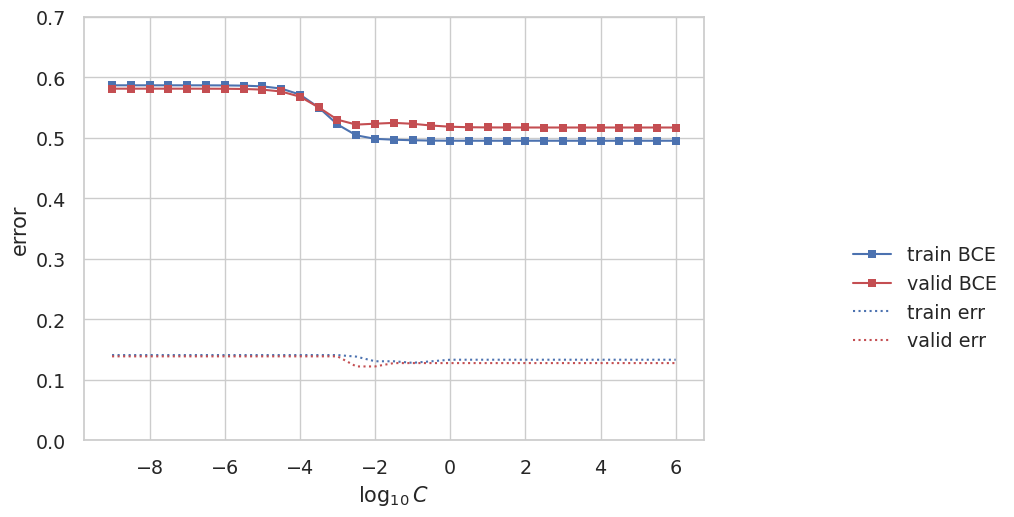

In [84]:
plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

### Check Point:

If your code is correct, you should produce exactly the same figure when you run the cell above as:

**"Checkpoint1C.jpg"** in the same folder as your starter code.
![image.png](Checkpoint1C.JPG)

In [85]:
print("Searched over these C values:")
print(C_grid)

print("Recorded these BCE loss values on val set")
print(va_bce_list)

Searched over these C values:
[1.00000000e-09 3.16227766e-09 1.00000000e-08 3.16227766e-08
 1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06]
Recorded these BCE loss values on val set
[0.5813486462944975, 0.5813483116634849, 0.5813472417933673, 0.5813438668569002, 0.5813332021657565, 0.5812994793055624, 0.5811930178568904, 0.5808580497615957, 0.579815561667335, 0.5766778884024558, 0.5681388958678034, 0.5504170795820452, 0.5300315902569899, 0.5219479609614884, 0.5234818733958239, 0.524841598520725, 0.5232951289242516, 0.5204234457386387, 0.5184462822989552, 0.5176008412722334, 0.5173046331390778, 0.517207715905226, 0.51717673853773

**TODO** Find the best C with the samllest cross entropy loss on the validation set.

In [86]:
# Find the best C with the smallest cross entropy loss on the validation set
best_index = np.argmin(va_bce_list)
best_C__lrF2 = va_bce_list[best_index] # TODO fixme

print("Best C value for F2 model:")
print(best_C__lrF2)

Best C value for F2 model:
0.5171623520834977


**TODO** Load the model that was rated 'best'

In [87]:
best_lrF2 = model_F2_list[best_index] # TODO fixme

print("Best model has coefficient values:")
print(best_lrF2.coef_)

Best model has coefficient values:
[[0.23884106 0.43491962]]


In [88]:
# Output the prediction of your best model for 2-feature data on the training, valid, and test set. 
# Return the posibility of predicting true
# We'll use them for the ROC curve
bestlrF2_yproba1_tr_M = best_lrF2.predict_proba(x_tr_M2)[:,1]
bestlrF2_yproba1_va_N = best_lrF2.predict_proba(x_va_N2)[:,1]
bestlrF2_yproba1_te_N = best_lrF2.predict_proba(x_te_N2)[:,1]

## Implementation Step 1D : Logistic Regression with F=3 dataset
**TODO**: 
* Repeat Step 1C for 3-feature Dataset to find the best C. 

In [89]:
C_grid = np.logspace(-9, 6, 31)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

model_F3_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list3 = list()
va_bce_list3 = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list3 = list()
va_err_list3 = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F3
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 3-feature dataset
    lr_F3 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C)
    lr_F3.fit(x_tr_M3, y_tr_M) 
    
    model_F3_list.append(lr_F3)
    
    yproba1_tr_M3 = lr_F3.predict_proba(x_tr_M3)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N3 = lr_F3.predict_proba(x_va_N3)[:,1] # The probability of predicting class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err3 = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err3 = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list3.append(my_tr_err)
    va_err_list3.append(my_va_err)
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce3 = calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M) # TODO fixme
    my_va_bce3 = calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N) # TODO fixme
    # Save bce for future selection on Models.
    tr_bce_list3.append(my_tr_bce) 
    va_bce_list3.append(my_va_bce) 

**TODO**:
* Select the best C and retrieve the best model. You should name the model as "**best_lrF3**".

In [90]:
# Find the best C with the smallest cross entropy loss on the validation set
best_index3 = np.argmin(va_bce_list3)
best_C__lrF3 = va_bce_list[best_index3]

print("Best C value for F3 model:")
print(best_C__lrF3)

best_lrF3 = model_F3_list[best_index] 

print("Best model has coefficient values:")
print(best_lrF3.coef_)

Best C value for F3 model:
0.5813486462944975
Best model has coefficient values:
[[0.26004524 0.52017581 0.78979623]]


**TODO**:
* Return the posibility of predicting true on training, validation and test set.

In [91]:
# TODO: Return the posibility of predicting true on training, validation and test set.
# Hint: follow what's done in the last code block of Step 1C.

prng = np.random.RandomState(101)
bestlrF3_yproba1_tr_M = best_lrF3.predict_proba(x_tr_M3)[:,1] 
bestlrF3_yproba1_va_N = best_lrF3.predict_proba(x_va_N3)[:,1]
bestlrF3_yproba1_te_N = best_lrF3.predict_proba(x_te_N3)[:,1]

## Implementation Step 1E : Comparing Models using ROC Analysis
**TODO**:
Follow the instruction to produce the figure for your report

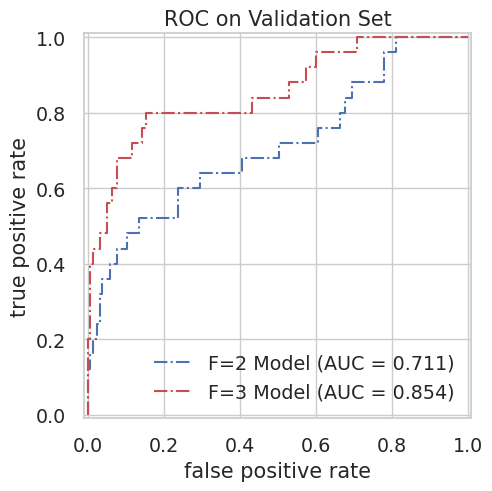

In [92]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided data and predictions on the Validation set
# Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 

# ROC curve for 2-feature model
fpr2, tpr2, thresholds2 = sklearn.metrics.roc_curve(y_va_N, yproba1_va_N)
roc_auc2 = sklearn.metrics.auc(fpr2, tpr2)

# ROC curve for 3-feature model 
fpr3, tpr3, thresholds3 = sklearn.metrics.roc_curve(y_va_N, yproba1_va_N3)
roc_auc3 = sklearn.metrics.auc(fpr3, tpr3)

# Read HW2 instructions carefully for plot style (line type, line color, etc.)
plt.plot(fpr2, tpr2, color='b', linestyle='-.', label='F=2 Model (AUC = {:.3f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='r', linestyle='-.', label='F=3 Model (AUC = {:.3f})'.format(roc_auc3))

plt.title("ROC on Validation Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

### Figure 1 for the report: Comparing models using ROC analysis
**TODO**:
Show the figure above in your report

#### Short Answer 1b

Compare the two models in terms of their ROC curves from Figure 1. Does one dominate the other in terms of overall performance across all thresholds, or are there some threshold regimes where the 2-feature model is preferred and other regimes where the 3-feature model is preferred? Which model do you recommend for the task at hand?

A perfect classifier would have a TPR of 1 and a FPR of 0; the closer you get to a linear pattern, the more random the classifier. Since the F=3 model has a higher AUC (0.854) compared to the F=2 model AUC (0.711), the F=3 model is preferred. The F=3 curve is closer to the perfect classifier compared to F=2 by the shape of the graph. 

## Selecting a decision threshold

Now that we've compared models, we need to decide on a classification *threshold* to obtain a binary decision from probabilities. 

To get candidate threshold values, use the helper function `compute_perf_metrics_across_thresholds` in the starter code file [threshold_selection.py](https://github.com/tufts-ml-courses/cs135-23f-assignments/blob/main/hw2/threshold_selection.py).

#### Implementation Step 1F

For the classifier from 1D above (LR for 3-features), calculate performance metrics using the default threshold of `y_proba < 0.5`. Produce the confusion matrix and calculate the TPR and PPV. 
*Tip: Remember that we have implemented helper functions for you in `confusion_matrix.py`.*

TODO:

* Use F=3 LR model, Use default 0.5 threshold
* Produce the confusion matrix
* Return TPR and PPV on the test set

In [102]:
# predicted probs from log regr model
y_proba_test = best_lrF3.predict_proba(x_te_N3)[:, 1]

# use the threshold selection function to get candidate thresholds and performance metrics
thresh_grid, perf_dict = threshold_selection.compute_perf_metrics_across_thresholds(y_te_N, y_proba_test, thresh_grid=None)
acc_grid = perf_dict['acc']
tpr_grid = perf_dict['tpr']
ppv_grid = perf_dict['ppv']

# make confusion matrix
best_thr_default = 0.5
y_pred_test = (y_proba_test >= best_thr_default).astype(int)
conf_mat_test = calc_confusion_matrix_for_probas_and_threshold(y_te_N, y_pred_test, best_thr_default)
print(conf_mat_test)
tn = conf_mat_test.iloc[0, 0]
fp = conf_mat_test.iloc[0, 1]
fn = conf_mat_test.iloc[1, 0]
tp = conf_mat_test.iloc[1, 1]
#tn, fp, fn, tp = conf_mat_test[0,0], conf_mat_test[0,1], conf_mat_test[1,0], conf_mat_test[1, 1]
#print(conf_mat_test)

tpr = tp / (tp + fn + 1e-6) # TODO fixme
ppv = tp / (tp + fp + 1e-6) # TODO fixme

print(f"Default threshold (0.5): chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

Predicted    0   1
True              
0          152   3
1           15  10
Default threshold (0.5): chosen thr = 0.5000, tpr = 0.4000, ppv = 0.7692,


### Implementation Step 1G

For the classifier from 1D above (LR for 3-features), compute performance metrics across all candidate thresholds on the validation set (use `compute_perf_metrics_across_thresholds`). Then, pick the threshold that *maximizes TPR while satisfying PPV >= 0.98* on the validation set.
If there's a tie for the maximum TPR, chose the threshold corresponding to a higher PPV. 

Remember, you pick this threshold based on the *validation* set, then later you'll evaluate it on the *test* set.

**TODO**: Finish the code block to get the best threshold.

In [106]:
# Get the performance metrics across many thresholds
thresh_grid, va_perf_grid = threshold_selection.compute_perf_metrics_across_thresholds(
    y_va_N, bestlrF3_yproba1_va_N)

In [103]:
# Find threshold that makes TPR as large as possible, while satisfying PPV >= 0.98
# TODO Find the the largest TPR while PPV >= 0.98

# compute performance metrics across validation set
y_proba_va = best_lrF3.predict_proba(x_va_N3)[:, 1]
thresh_grid, perf_dict = threshold_selection.compute_perf_metrics_across_thresholds(y_va_N, y_proba_va)

# extract tpr and ppv from perf_dict
tpr_grid = perf_dict['tpr']
ppv_grid = perf_dict['ppv']

# indices where PPV >=0.98
ppv98_ind = np.where(ppv_grid >= 0.98)[0]

# finding max TPR
max_tpr_ind = ppv98_ind[np.argmax(tpr_grid[ppv98_ind])]

best_thr_tpr = thresh_grid[max_tpr_ind] # TODO fixme
tpr1 = tpr_grid[max_tpr_ind] # TODO fixme
ppv1 = ppv_grid[max_tpr_ind] # TODO fixme

print(f"Figure2 column 2: chosen thr = {best_thr_tpr :.4f}, tpr = {tpr1 :.4f}, ppv = {ppv1 :.4f},")

Figure2 column 2: chosen thr = 0.6311, tpr = 0.2000, ppv = 1.0000,


**TODO**: Using the chosen **best_thr** above
* Produce the confusion matrix on the test set
* Return TPR and PPV on the test set

In [104]:
y_pred_test_tpr = (y_proba_test >= best_thr_tpr).astype(int)
conf_mat_test_tpr = calc_confusion_matrix_for_probas_and_threshold(y_te_N, y_pred_test_tpr, best_thr_tpr)
print(conf_mat_test_tpr)

tn = conf_mat_test_tpr.iloc[0, 0]
fp = conf_mat_test_tpr.iloc[0, 1]
fn = conf_mat_test_tpr.iloc[1, 0]
tp = conf_mat_test_tpr.iloc[1, 1]

tpr_test = tp / (tp + fn + 1e-6)
ppv_test = tp / (tp + fp + 1e-6)

print(f"At selected threshold, the TPR: {tpr_test:.4f} and the PPV: {ppv_test:.4f}" )


Predicted    0  1
True             
0          155  0
1           20  5
At selected threshold, the TPR: 0.2000 and the PPV: 1.0000


### Implementation Step 1H

Now using the same F=3 LR model, pick a threshold to maximize PPV s.t. TPR >= 0.98

TODO: 
Using a similar logistic from **Step 1F** above
* Choose threshold that makes PPV as large as possible, while satisfying TPR >= 0.98
* Produce the confusion matrix using the chosen threshold
* Return TPR and PPV on the test set using the chosen threshold

In [107]:
# TODO Find the largest PPV while TPR >= 0.98
tpr98_ind = np.where(tpr_grid >= 0.98)[0]

# finding max PPV
max_ppv_ind = tpr98_ind[np.argmax(ppv_grid[tpr98_ind])]

best_thr_ppv = thresh_grid[max_ppv_ind] # TODO fixme
tpr2 = tpr_grid[max_ppv_ind] # TODO fixme
ppv2 = ppv_grid[max_ppv_ind] # TODO fixme

print("Figure2 column 3: chosen thr = %.4f, tpr = %.4f, ppv = %.4f" % (best_thr_ppv, tpr2, ppv2))

y_pred_test_ppv = (y_proba_test >= best_thr_ppv).astype(int)
conf_mat_test_ppv = calc_confusion_matrix_for_probas_and_threshold(y_te_N, y_pred_test_ppv, best_thr_ppv)
print(conf_mat_test_ppv)

tn = conf_mat_test_ppv.iloc[0, 0]
fp = conf_mat_test_ppv.iloc[0, 1]
fn = conf_mat_test_ppv.iloc[1, 0]
tp = conf_mat_test_ppv.iloc[1, 1]

tpr_test2 = tp / (tp + fn + 1e-6)
ppv_test2 = tp / (tp + fp + 1e-6)

print(f"At selected threshold, the TPR: {tpr_test2:.4f} and the PPV: {ppv_test2:.4f}" )

Figure2 column 3: chosen thr = 0.0296, tpr = 1.0000, ppv = 0.1852
Predicted   0   1
True             
0          57  98
1           0  25
At selected threshold, the TPR: 1.0000 and the PPV: 0.2033


#### Short Answer 1c

By carefully reading the confusion matrices above, for *each thresholding strategy* how many subjects in the test set are saved from unnecessary biopsies that would be done in current practice?

*Hint*: You can assume that currently, the hospital would have done a biopsy on every patient in the test set. Your goal is to build a classifier that improves on this practice. 

number of subjects saved from biopsies = # of true negatives

number of subjects saved in 1F: 152 subjects - although there are 15 false negatives, meaning that those 15 people who need the biopsy will not receive it

number of subjects saved in 1G: 155 subjects - although there are 20 false negatives, meaning that those 20 people who need the biopsy will not receive it

number of subjects saved in 1H: 57 subjects

#### Short Answer 1d

Among the 3 possible thresholding strategies, which strategy best meets the stated goals of stakeholders in this screening task: avoid life-threatening mistakes whenever possible, while also eliminating unnecessary biopsies?
What fraction of current biopsies might be avoided if this strategy was adopted by the hospital? 

*Hint*: You can also assume the test set is a reasonable representation of the true population of patients.

For this implementation, false negatives are far more life-threatening than false positives. If someone is categorized into 'false negative', they need a biopsy but will not receive one. While we want to reduce the number of false positives to prevent unnecessary biopsies, I would prioritize having a low false negative number and therefore choose implementation method 1H. The fraction of biopsies that may be avoided with this strategy is 57/180 or about 32%. 

# Reflection

1. How many hours, approximatley, did this homework take you? 5 hours
2. What did you feel was most confusing about this homework?
3. Did you recieve help on this homework from any classmates, stack overflow threads, AI tools, Youtube videos, etc. for this homework? If so, please list them here. 
- stackoverflow for error troubleshooting
- pandas, numpy, python, and scikitlearn documentation 